In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

In [11]:
import matplotlib.font_manager as fm
sys_font=fm.findSystemFonts()
nanum_font = [f for f in sys_font if 'Nanum' in f]

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7fbd50023e10>)

In [4]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [7]:
total_data['ratings'].value_counts()

5    81177
2    63989
1    36048
4    18786
Name: ratings, dtype: int64

In [ ]:
idxs = []
for rank in [1, 2, 3, 4, 5]:
    idxs.extend(total_data[total_data['ratings'] == rank]['ratings'][:2000].index.tolist())

In [56]:
samples = total_data.iloc[idxs, :]
samples['ratings'].value_counts()

2    2000
5    2000
1    2000
4    2000
Name: ratings, dtype: int64

## preprocess

In [51]:
import re 
def clean_text(texts): 
    # tag 특수문자 제거
    review = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》;]', '', texts)
    # review = re.sub(r'\d+','', str(texts[i]))# remove number 
    # 한글 제외 제거
    review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review)
    # 띄어쓰기 제거
    review = re.sub(r'\s+', ' ', review) 
    # html tag 제거
    review = re.sub(r'<[^>]+>','',review)
    # 시작 스페이스 제거
    review = re.sub(r"^\s+", '', review) 
    # 끝 스페이스 제거
    review = re.sub(r'\s+$', '', review) 
    return review

In [ ]:
samples['reviews'] = samples['reviews'].apply(lambda x: clean_text(str(x)))
samples['reviews'].replace('', np.nan, inplace=True)
print(samples.isnull().sum())

# Null 값이 존재하는 행 제거
samples = samples.dropna(how = 'any')

In [63]:
# 맞춤법 검사
from hanspell import spell_checker

samples['reviews'] = samples['reviews'].apply(lambda x:spell_checker.check(x).checked)

In [5]:
# token
import numpy as np
import pandas as pd
from konlpy.tag import Okt

okt = Okt()
stop_words=set(['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한'])

def preprocess(sentence):
    word_to_id = {}
    id_to_word = {}

    # 토큰화
    token = [okt.morphs(words) for words in sentence if isinstance(words, str)]

    # 불용어
    for i, words in enumerate(token):
        token[i] = [word for word in words if not word in stop_words]
    
    # word2dict
    for words in token:
        for word in words:
            if  word not in word_to_id.keys():
                new_id = len(word_to_id)
                word_to_id[word] = new_id
                id_to_word[new_id] = word 
    
    # 말뭉치
    corpus_ar = []
    for words in token:
        for word in words:
            corpus = [word_to_id[word] for word in words]
        corpus_ar.append(corpus)
    del corpus
    return np.array(corpus_ar), word_to_id, id_to_word, token

In [8]:
corpus, word_to_id, id_to_word, token = preprocess(samples['reviews'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## 문장 및 단어 길이 확인

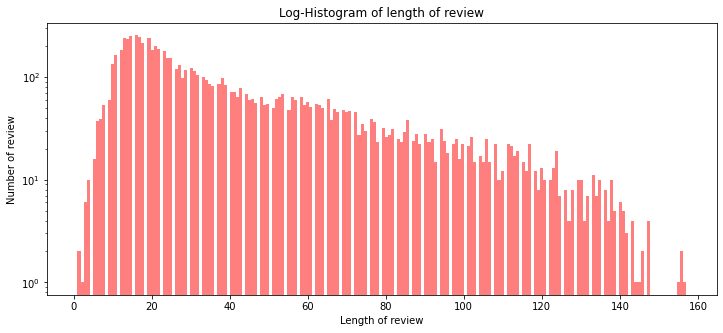

In [13]:
# 문장 평균 길이
plt.figure(figsize=(12,5))

plt.hist(samples['reviews'].astype(str).apply(len), bins=200, alpha=0.5, color='r', label='word')
plt.yscale('log',nonposy='clip')
plt.title('Log-Histogram of length of review')
plt.xlabel('Length of review')
plt.ylabel('Number of review')
plt.show()

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


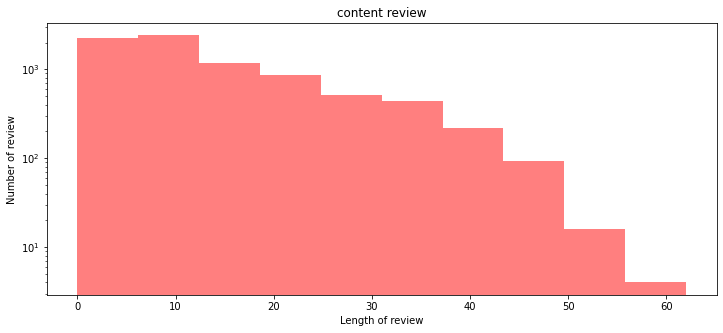

In [10]:
# 단어 평균 개수
plt.figure(figsize=(12,5))

plt.hist([len(words) for words in token], alpha=0.5, color='r', label='word')
plt.yscale('log',nonposy='clip')
plt.title('content review')
plt.xlabel('Length of review')
plt.ylabel('Number of review')
plt.show()

# bocab -> 50으로 결정!

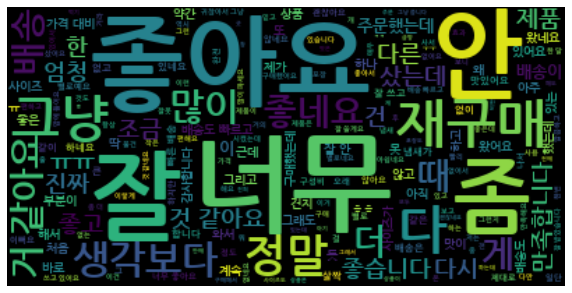

In [13]:
# 단어 구성 보기
from wordcloud import WordCloud

wordcloud=WordCloud(font_path=nanum_font[1]).generate(' '.join(samples['reviews']))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()